<a href="https://colab.research.google.com/github/raj-vijay/mv/blob/master/05_Lab_4_Interest_Points_on_House.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [0]:
def calculate_gradients(img, sigma_d):
    x,y = np.meshgrid(np.arange(6*sigma_d),np.arange(6*sigma_d))        
    dog_kernel_x = -(x-len(x)/2)*np.exp(-((x-len(x)/2)**2+(y-len(y[1])/2)**2)/(2*sigma_d**2))/(2*np.pi*sigma_d**4)    
    dog_kernel_y = -(y-len(y[1])/2)*np.exp(-((x-len(x)/2)**2+(y-len(y[1])/2)**2)/(2*sigma_d**2))/(2*np.pi*sigma_d**4)     
    dog_x = cv2.filter2D(img.astype('float'), -1, dog_kernel_x)
    dog_y = cv2.filter2D(img.astype('float'), -1, dog_kernel_y)
    return dog_x,dog_y

In [0]:
def calculate_structure_tensors(gx,gy,sigma_w):
    x,y = np.meshgrid(np.arange(6*sigma_w),np.arange(6*sigma_w))        
    r = np.sqrt((x-len(x)/2)**2 + (y-len(y[1])/2)**2)
    w = np.exp(-(r-len(r)/2)**2/(2*sigma_w**2))/(sigma_w*np.sqrt(2*np.pi))
    S={}
    for x in range(len(gx)-len(w)):
        for y in range(len(gx[0])-len(w[1])):
            gxgx = np.dot((w*gx[x:x+len(w),y:y+len(w)]).flatten(),
                          (gx[x:x+len(w),y:y+len(w)]).flatten())
            gxgy = np.dot((w*gx[x:x+len(w),y:y+len(w)]).flatten(),
                          (gy[x:x+len(w),y:y+len(w)]).flatten())
            gygy = np.dot((w*gy[x:x+len(w),y:y+len(w)]).flatten(),
                          (gy[x:x+len(w),y:y+len(w)]).flatten())
            S[(x,y)] = np.array([[gxgx,gxgy],[gxgy,gygy]])
    return S,len(w)

In [0]:
def calculate_interest_metric(S):
    size = max(S.keys())
    shi_tomasi = np.zeros((size[0]+1,size[1]+1))
    for x,y in S:
        lambdas = np.linalg.eigvals(S[(x,y)])
        shi_tomasi[x,y] = np.min(lambdas)
    return shi_tomasi

In [0]:
def non_maximum_suppression(metric,T):
    points = []
    for x in range(1,len(metric)-1):
        for y in range(1,len(metric[0])-1):
            if ((metric[x,y]>T) and
                (metric[x,y]>metric[x-1,y-1]) and
                (metric[x,y]>metric[x-1,y]) and
                (metric[x,y]>metric[x-1,y+1]) and
                (metric[x,y]>metric[x,y-1]) and
                (metric[x,y]>metric[x,y+1]) and
                (metric[x,y]>metric[x+1,y-1]) and
                (metric[x,y]>metric[x+1,y]) and
                (metric[x,y]>metric[x+1,y+1])):
                points.append((x,y))
    return points

In [8]:
# Download the house image using wget (Linux)
!wget https://raw.githubusercontent.com/raj-vijay/mv/master/images/house.png

--2020-03-02 23:03:33--  https://raw.githubusercontent.com/raj-vijay/mv/master/images/house.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37593 (37K) [image/png]
Saving to: ‘house.png’

house.png           100%[===================>]  36.71K  --.-KB/s    in 0.01s   

2020-03-02 23:03:38 (3.17 MB/s) - ‘house.png’ saved [37593/37593]



[(1, 86), (1, 121), (2, 62), (2, 64), (2, 133), (3, 110), (4, 148), (5, 58), (7, 121), (8, 86), (8, 125), (9, 49), (9, 58), (9, 63), (9, 79), (10, 65), (10, 133), (10, 157), (11, 69), (12, 148), (13, 102), (13, 116), (14, 73), (15, 118), (15, 144), (16, 125), (16, 149), (17, 132), (17, 154), (18, 58), (18, 94), (19, 135), (19, 168), (21, 145), (21, 168), (21, 175), (22, 67), (22, 73), (23, 50), (23, 117), (23, 153), (24, 126), (25, 54), (25, 58), (25, 174), (26, 168), (27, 25), (27, 74), (27, 98), (28, 70), (28, 91), (28, 96), (28, 141), (29, 153), (29, 159), (29, 168), (30, 40), (30, 117), (31, 44), (32, 31), (32, 35), (33, 138), (34, 55), (34, 64), (34, 90), (34, 146), (34, 166), (34, 231), (35, 4), (35, 12), (35, 70), (35, 99), (36, 159), (36, 216), (37, 90), (38, 17), (38, 22), (38, 28), (38, 39), (38, 56), (38, 136), (38, 225), (39, 45), (39, 63), (39, 66), (39, 164), (40, 15), (40, 17), (40, 51), (40, 54), (40, 112), (40, 146), (40, 155), (40, 234), (42, 137), (42, 240), (43, 62)

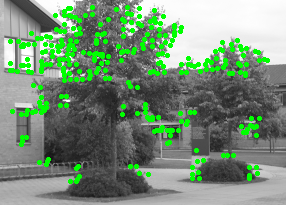

True

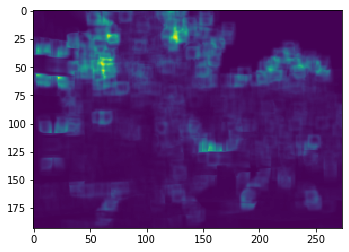

In [9]:
input_image = cv2.imread("house.png")
# cv2.imshow("input", input_image)

img = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)

sigma_d = 1
gx,gy = calculate_gradients(img, sigma_d)    

# plt.figure()
# plt.imshow(gx)
# plt.figure()
# plt.imshow(gy)

sigma_w = 2
S,w = calculate_structure_tensors(gx,gy,sigma_w)        
w = int(w/2)

metric = calculate_interest_metric(S)

plt.figure()
plt.imshow(metric)

T = 1000
points = non_maximum_suppression(metric, T)    
print(points)


for point in points:
    cv2.circle(input_image, (point[1]+w,point[0]+w), 1, (0,255,0), 2)

cv2_imshow(input_image)
cv2.imwrite("result.jpg", input_image)